## **Nigeria flooding study**

In [2]:
import sys; sys.path.append('/home/clair/WWA'); from wwa import *

---
### **Define catchments**

In [2]:
# Lake Chad catchment
gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[39]].to_file("00_regions/sf_lake-chad")

# Region around Lagdo Dam
gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev05").loc[[407]].to_crs(epsg = "4326").to_file("00_regions/sf_lagdo-dam")

# Lower Niger
states = gpd.read_file("00_regions/nigeria-lgas").to_crs(epsg = "4326")
nb = gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[16]]
pd.concat([nb.clip(states), gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev04").loc[[93,98]]]).dissolve().to_file("00_regions/sf_lower-niger")

In [4]:
# extract lat & lon, save as points for easier upload to Climate Explorer
for fnm in ["sf_lower-niger", "sf_lake-chad", "sf_lagdo-dam"]:
    
    gdf = gpd.read_file("00_regions/"+fnm)
    px = gdf.geometry[0].exterior.coords.xy
    pd.DataFrame(px, index = ["#lon", "lat"]).transpose().to_csv("00_regions/"+fnm+"_latlon.txt", index = None, sep = " ")

In [5]:
# also list affected states (mentioned in news stories in )
aff = ['Abia', 'Adamawa', 'Anambra', 'Bauchi', 'Bayelsa', 'Benue', 'Borno', 'Cross River', 'Delta', 'Ebonyi', 'Edo', 'Gombe',
        'Imo', 'Jigawa', 'Kano', 'Kebbi', 'Kogi', 'Lagos', 'Niger', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe', 'Zamfara']
states = gpd.read_file("00_regions/nigeria-lgas")
states = states.loc[[s in aff for s in states.STATE]].dissolve("STATE")
states.to_file("00_regions/sf_affected-states")

### **Comparison of timescales**

In [38]:
pr_ln = xr.open_dataset("obs/chirps_lower-niger_daily.nc").precip

In [ ]:
labelticks = [i for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]
labels = [pr.sel(time = slice("20180101", "20190101")).time[i].values for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]

colours = ["orchid", "skyblue", "gold", "yellowgreen", "darkgreen", "orange"]

In [43]:
for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(figsize = (6,4), dpi = 100, sharey = False)
    
    for i in range(1):
        ax = plt.gcf().axes[i]
        ts = pr_ln.rolling(time = ndays, center = False).mean()
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("lower-niger_"+str(ndays)+"-day-precip.png"); plt.close()

### **Maps of study region**

In [6]:
lake_chad = gpd.read_file("00_regions/sf_lake-chad")
lagdo_dam = gpd.read_file("00_regions/sf_lagdo-dam")
lower_niger = gpd.read_file("00_regions/sf_lower-niger")

# also load rivers shapefile
niger_benue = gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev03").iloc[[16]].to_crs(epsg = "4326")
rv = gpd.read_file("00_regions/africa-rivers").to_crs(epsg = "4326").clip(pd.concat([niger_benue, lake_chad]))


#### **Schematic of catchments**

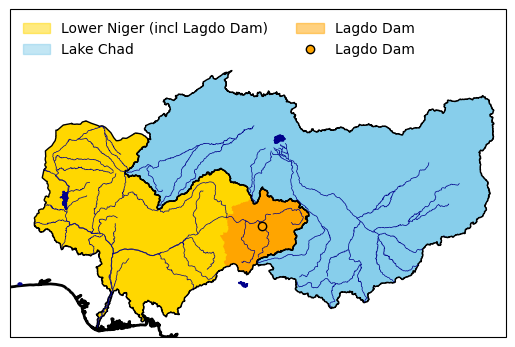

In [15]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1)
ax.coastlines(lw = 2)

lower_niger.plot(ax = ax, color = "gold")
lake_chad.plot(ax = ax, color = "skyblue")
lagdo_dam.plot(ax = ax, color = "orange")

rv.loc[rv.RIVERS_ID <= 6.0].clip(pd.concat([lower_niger, lake_chad])).plot(ax = ax, color = "darkblue", lw = 0.5)
ax.add_feature(cartopy.feature.LAKES, color = "darkblue")

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
# ax.annotate("Lagdo\nDam", xy = get_latlon("Lagdo Dam").values(), fontweight = "bold", textcoords="offset points", xytext=(5,-8), ha='left')

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["gold", "skyblue", "orange"],
                                                                                                 ["Lower Niger (incl Lagdo Dam)", "Lake Chad", "Lagdo Dam"])] + 
           [matplotlib.lines.Line2D([], [], marker = "o", color = "orange", mec = "k", ls = "None", label = "Lagdo Dam")], 
           ncol = 2, edgecolor = "w", loc = "upper left")

ax.set_extent((2,25,4,19))

plt.savefig("study-regions.png")

#### **Elevation**

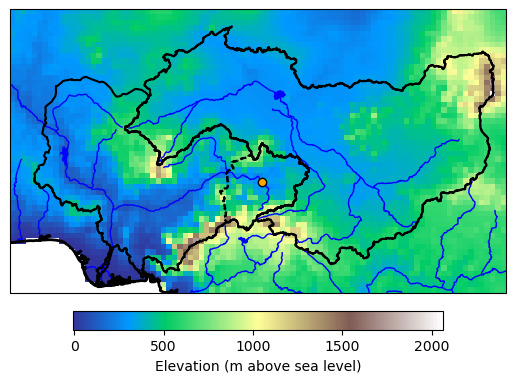

In [18]:
# topography
elev = xr.open_dataset("../90_data/elevation-0.25deg-global.nc").elev

# mask land surface
lsm = regionmask.mask_3D_geopandas(gpd.read_file("00_regions/hybas_af_lev01-12_v1c/lev01"), elev.lon, elev.lat, drop = False).squeeze(drop = True)
elev = elev.where(lsm).dropna("lat", "all").dropna("lon", "all").sel(lon = slice(2,25), lat = slice(4,17))

elev.plot(center = False, cmap = "terrain", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
          cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Elevation (m above sea level)"})
ax = plt.gcf().axes[0]

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1.5)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1.5)
lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1.5, ls = "--")

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.add_feature(cartopy.feature.LAKES, color = "blue")

ax.coastlines(lw = 2)

plt.savefig("study-regions-topography.png")

#### **Affected regions**

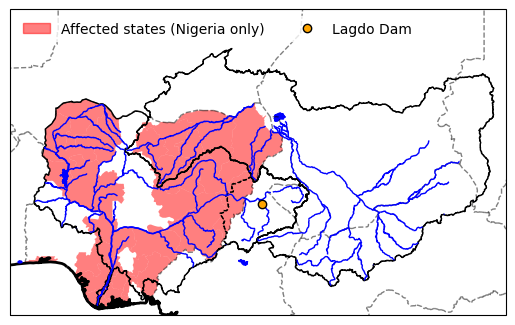

In [20]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

lower_niger.boundary.plot(ax = ax, color = "k", lw = 1)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 1)
lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--")
ax.coastlines(lw = 2)

gpd.read_file("00_regions/sf_affected-states").plot(ax = ax, color = "red", alpha = 0.5)

rv.loc[rv.RIVERS_ID <= 6.0].clip(pd.concat([lower_niger, lake_chad])).plot(ax = ax, color = "blue", lw = 1)
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["red"], ["Affected states (Nigeria only)"])] + 
           [matplotlib.lines.Line2D([], [], marker = "o", color = "orange", mec = "k", ls = "None", label = "Lagdo Dam")], 
           ncol = 2, edgecolor = "w", loc = "upper left")

ax.set_extent((2,25,4,18))

plt.savefig("study-regions-affected-states.png")

### **Observations**

In [3]:
chirps = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(-13,27), latitude = slice(0,25))
tamsat = xr.open_mfdataset("../02_tamsat/tamsat_*_rfe-filled_0.25.v3.1.nc").rfe_filled.sel(lon = slice(-13,27), lat = slice(0,25)).rename(lat = "latitude", lon = "longitude").load()

#### **Daily time series per catchment**

In [4]:
for cmt in ["lake-chad", "lagdo-dam", "lower-niger"]:
    for ds in ["chirps", "tamsat"]:
        
        da = eval(ds)
        da = da.where(regionmask.mask_3D_geopandas(gpd.read_file("00_regions/sf_"+cmt), da.longitude, da.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])
        da.to_netcdf("obs/"+ds+"_"+cmt+"_daily.nc")

#### **Seasonal cycles**

In [34]:
chirps = xr.concat([xr.open_dataset(fnm).expand_dims(catchment = [re.sub("_.+", "", re.sub(".+chirps_", "", fnm))]) for fnm in sorted(glob.glob("obs/chirps_*.nc"))], "catchment").precip
tamsat = xr.concat([xr.open_dataset(fnm).expand_dims(catchment = [re.sub("_.+", "", re.sub(".+tamsat_", "", fnm))]) for fnm in sorted(glob.glob("obs/tamsat_*.nc"))], "catchment").rfe_filled.rename("precip")

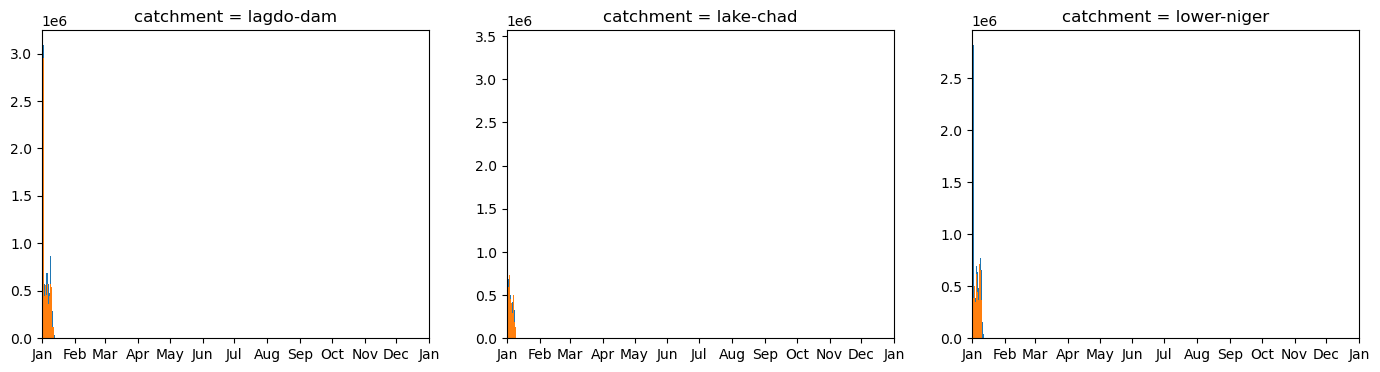

In [35]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (17,4))

for i in range(3):

    chirps.isel(catchment = i).groupby("time.dayofyear").mean().plot(ax = axs[i])
    tamsat.isel(catchment = i).groupby("time.dayofyear").mean().plot(ax = axs[i])
        
    month_xlabels(chirps.sel(time = slice("20180101", "20190101")).time, ax = axs[i])
    axs[i].set_xlabel("")

#### **Spatial patterns**

In [ ]:
# get JJAS spatial pattern per year

chirps = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(-13,27), latitude = slice(-5,25))
chirps = chirps.sel(time = [m in [6,7,8,9] for m in chirps.time.dt.month]).resample(time = "AS").mean()
chirps.to_netcdf("obs/chirps_spatial_jjas-yearly.nc")

tamsat = xr.open_mfdataset("../02_tamsat/tamsat_*_rfe-filled_0.25.v3.1.nc").rfe_filled.sel(lon = slice(-13,27), lat = slice(-5,25))
tamsat = tamsat.sel(time = [m in [6,7,8,9] for m in tamsat.time.dt.month]).resample(time = "AS").mean()
tamsat.to_netcdf("obs/tamsat_spatial_jjas-yearly.nc")

In [38]:
# plots of spatial patterns
chirps = xr.open_dataset("obs/chirps_spatial_jjas-yearly.nc").precip
tamsat = xr.open_dataset("obs/tamsat_spatial_jjas-yearly.nc").rfe_filled

Text(0.5, 0.98, 'Mean daily precipitation during JJAS 1985-2022')

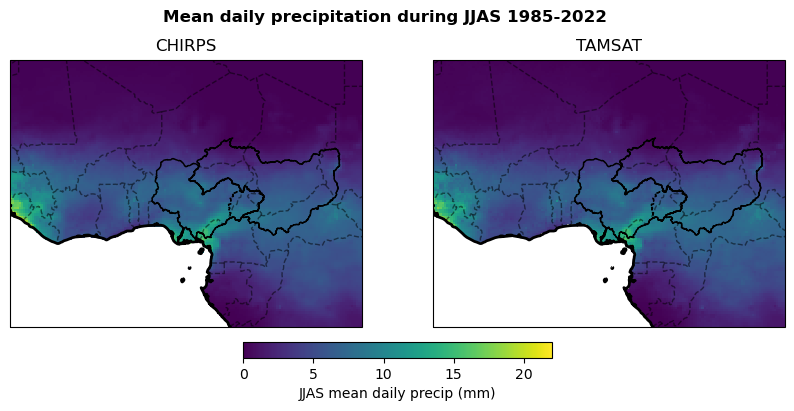

In [92]:
plot_years = slice("1985", "2022")
plot_kwargs = {"add_colorbar" : False, "vmin" : 0, "vmax" : np.ceil(max([da.sel(time = plot_years).mean("time").max().values for da in [chirps, tamsat]]))}

fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
chirps.sel(time = plot_years).mean("time").plot(ax = axs[0], **plot_kwargs)
axs[0].set_title("CHIRPS")
cbar = tamsat.sel(time = plot_years).mean("time").plot(ax = axs[1], **plot_kwargs)
axs[1].set_title("TAMSAT")

for ax in axs:
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    lower_niger.boundary.plot(ax = ax, color = "k", lw = 1)
    lake_chad.boundary.plot(ax = ax, color = "k", lw = 1)
    lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--")

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.05, label = "JJAS mean daily precip (mm)")

fig.suptitle("Mean daily precipitation during JJAS "+plot_years.start+"-"+plot_years.stop, fontweight = "bold")

#### **Attribution time series**

In [6]:
# methods to compute time series for attribution

def jjas_mean(ts):
    jjas = ts.sel(time = [m in [6,7,8,9] for m in ts.time.dt.month]).resample(time = "AS").mean()
    return jjas

def max_7day(ts):
    ts7 = ts.rolling(time = 7, center = False).mean()
    ts7 = ts7.sel(time = [m in [6,7,8,9] for m in ts7.time.dt.month]).resample(time = "AS").max()
    return ts7

def cx_csv(ts, fnm):
    
    # relabel time dimension & output to csv
    ts.assign_coords(time = ts.time.dt.year).rename(time = "#year").to_dataframe().to_csv(fnm, sep = " ")
    
    # add a line specifying the model & variable name, to be used as filename when uploading
    fnm_string = "# "+ re.sub("\\.txt", "", re.sub(".+/", "", fnm))
    ! echo "$fnm_string" >> $fnm

In [5]:
# Lake Chad: mean JJAS precipitation
for ds in ["chirps", "tamsat"]:
    
    fnm = "obs/"+ds+"_lake-chad_daily.nc"
    ts_jjas = jjas_mean(xr.open_dataset(fnm))
    cx_csv(ts_jjas,  re.sub("daily.nc", "jjas-mean.txt", fnm))

In [6]:
# Lower Niger: annual maximum of 7-day accumulated precipitation
for ds in ["chirps", "tamsat"]:
    
    # load data, select precip variable
    fnm = "obs/"+ds+"_lower-niger_daily.nc"
    ts7 = max_7day(xr.open_dataset(fnm))
    
    cx_csv(ts7, fnm = re.sub("daily.nc", "7day-max.txt", fnm))

In [30]:
ts = pd.read_csv("obs/chirps_lower-niger_7day-max.txt", sep = " ", index_col = "#year")

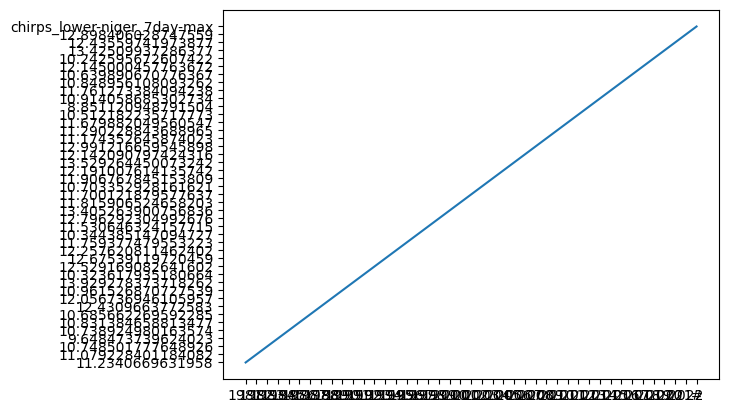

#### **Maps of the event definition**

In [4]:
chirps = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(0,27), latitude = slice(0,20))

In [7]:
chirps_jjas = jjas_mean(chirps)

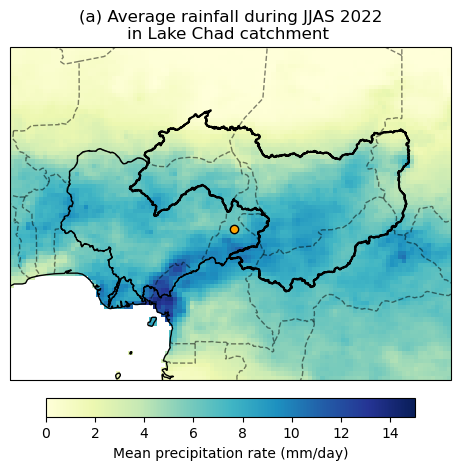

In [51]:
chirps_jjas.sel(time = "2022").plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "YlGnBu",
                                   cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Mean precipitation rate (mm/day)"})
ax = plt.gcf().axes[0]
gpd.read_file("00_regions/sf_lower-niger").boundary.plot(ax = ax, color = "k", lw = 1)
gpd.read_file("00_regions/sf_lake-chad").boundary.plot(ax = ax, color = "k")

ax.set_title("(a) Average rainfall during JJAS 2022\nin Lake Chad catchment ")

ax.coastlines()

plt.savefig("chirps-chad-jjas.png")

ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
plt.savefig("chirps-chad-jjas_with-borders.png")

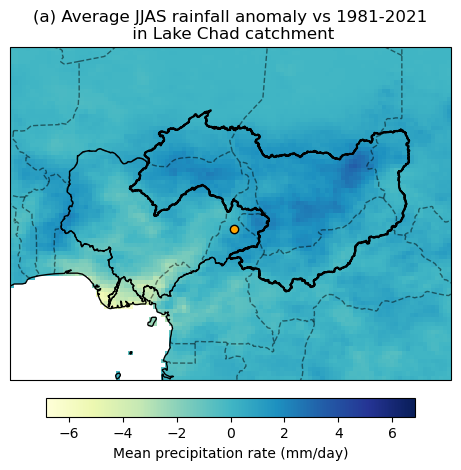

In [50]:
(chirps_jjas.sel(time = "2022") - chirps_jjas.sel(time = slice(None, "2021")).mean("time")).plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "YlGnBu",
                                                                cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Mean precipitation rate (mm/day)"})

ax = plt.gcf().axes[0]
gpd.read_file("00_regions/sf_lower-niger").boundary.plot(ax = ax, color = "k", lw = 1)
gpd.read_file("00_regions/sf_lake-chad").boundary.plot(ax = ax, color = "k")
ax.set_title("(a) Average JJAS rainfall anomaly vs 1981-2021\n in Lake Chad catchment")
ax.coastlines()

plt.savefig("chirps-chad-jjas-anomaly.png")

ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
plt.savefig("chirps-chad-jjas-anomaly_with-borders.png")


In [12]:
chirps_7day = chirps.rolling(time = 7, center = False).mean().sel(time = "2022").round(3)

In [13]:
# identify date of heaviest 7-day accumulation across the whole catchment
ln_7day = chirps_7day.where(regionmask.mask_3D_geopandas(gpd.read_file("00_regions/sf_lower-niger"), chirps_7day.longitude, chirps_7day.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])
max7 = ln_7day.idxmax()

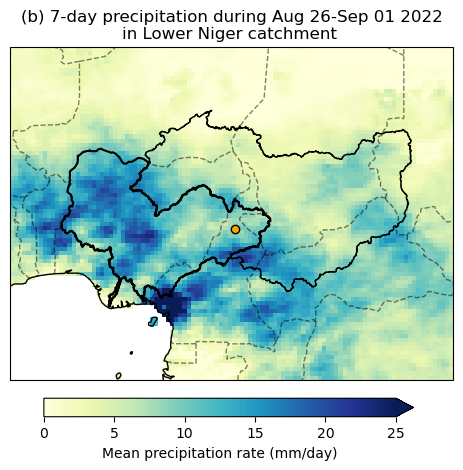

In [49]:
chirps_7day.sel(time = max7).plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "YlGnBu",
                                   cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Mean precipitation rate (mm/day)"}, vmax = 25)
ax = plt.gcf().axes[0]

gpd.read_file("00_regions/sf_lake-chad").boundary.plot(ax = ax, color = "k", lw = 1)
gpd.read_file("00_regions/sf_lower-niger").boundary.plot(ax = ax, color = "k")
ax.set_title("(b) 7-day precipitation during Aug 26-Sep 01 2022\nin Lower Niger catchment ")

ax.coastlines()

plt.savefig("chirps-lower-niger-7day.png")

ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)
ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
plt.savefig("chirps-lower-niger-7day_with-borders.png")

In [99]:
max7.dt.strftime("%b %d")

<xarray.DataArray 'strftime' ()>
array('Sep 01', dtype=object)